In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize

import copy



In [2]:
import gc
gc.collect()

0

In [3]:

import os
os.chdir("C:/Users/Meredith/Documents/GitHub/LDI-ML/")

In [4]:
fp = "MACHINE_LEARNING_PART/"
df = pd.read_csv(f"Adjusted Price.csv", index_col=0).set_index('period').dropna() # ARMA_output_Price
df_vol = pd.read_csv(f"Adjusted Volume.csv", index_col=0).set_index('period').dropna()

df.index = df.index.astype('int')
df_vol.index = df_vol.index.astype('int')
# Calculate Standard Deviation
#df['Std'] = (df.value - df.lower)/1.96
#df.loc[(df.lower==0)&(df.upper==0),'Std'] = 0

In [5]:
def fill_in_predictions(df):

    # Some start times are missing predictions, filling with next most recent predictions
    not_enough = np.in1d(df.start, df.start.value_counts() [df.start.value_counts() < df.start.max()+1].index)

    starts = df.start[~not_enough].unique()
    for start in df.start[not_enough].unique():

        copy_start = starts[starts<start].max()
        non_missing_rows = df.loc[df.start==start, :].index
        copy_rows = copy.deepcopy(df.loc[(df.start==copy_start)&~(np.in1d(df.index, non_missing_rows))])
        copy_rows.start=start
        copy_rows.offset = copy_rows.index - start
        

        copy_rows.loc[copy_rows.offset < 0, 'value'] = df.loc[df.start==df.start.max(), 'value']

        df = pd.concat([df, copy_rows]).drop_duplicates()

    return df
  

In [6]:
df_vol = fill_in_predictions(df_vol)
df = fill_in_predictions(df)

In [7]:
t = df.index.unique()

In [8]:
len(t)

168

In [9]:
df

,index,lower,upper,value,start,offset,Std,Higher,Probability Higher
period,,,,,,,,,
0,0.0,0.000000e+00,0.000000e+00,2.200000e+03,10.0,-10.0,0.000000e+00,True,0.500000
1,1.0,0.000000e+00,0.000000e+00,2.050000e+03,10.0,-9.0,0.000000e+00,True,0.500000
2,2.0,0.000000e+00,0.000000e+00,2.000000e+03,10.0,-8.0,0.000000e+00,False,0.500000
3,3.0,0.000000e+00,0.000000e+00,2.100000e+03,10.0,-7.0,0.000000e+00,True,0.500000
4,4.0,0.000000e+00,0.000000e+00,1.650000e+03,10.0,-6.0,0.000000e+00,False,0.500000
...,...,...,...,...,...,...,...,...,...
163,163.0,-5.485701e+07,3.594397e+07,-9.456518e+06,52.0,111.0,2.316352e+07,False,0.999929
164,164.0,-3.906527e+07,6.998512e+07,1.545993e+07,52.0,112.0,2.781898e+07,True,0.999973
165,165.0,-4.718546e+07,6.226628e+07,7.540411e+06,52.0,113.0,2.792136e+07,True,0.999965


In [10]:
def price(t, x, start=None, seed=None):
    if start is None:
        # Use best possible predictions by default
        start = max(df.start)
    if seed is None:
        # Return the predicted price
        return df.loc[df.start==start, :].loc[t, 'value'].clip(lower=0).values

    # Return a random variable generated using the predicted price and the standard deviation
    rng= np.random.default_rng(seed)
    return  np.maximum(rng.normal(loc=df.loc[df.start==start, :].loc[t, 'value'].values, scale=df.loc[df.start==start, :].loc[t, 'Std'].values), np.zeros_like(t))
    
def price_higher(t, x, start=None, seed=None, thresh=0.5):
    if start is None:
        # Use best possible predictions by default
        start = max(df.start)
    if seed is None:
        # Return the predicted price
        return (df.loc[df.start==start, :].loc[t, 'Probability Higher'] > thresh).values

    # Return a random variable generated using the predicted price and the standard deviation
    rng= np.random.default_rng(seed)
    return  np.maximum(rng.normal(loc=df.loc[df.start==start, :].loc[t, 'Higher'].values, scale=df.loc[df.start==start, :].loc[t, 'Std'].values), np.zeros_like(t))

def probability_higher(t, x, start=None, seed=None, thresh=0.5):
    if start is None:
        # Use best possible predictions by default
        start = max(df.start)
    if seed is None:
        # Return the predicted price
        return (df.loc[df.start==start, :].loc[t, 'Probability Higher']).values

    # Return a random variable generated using the predicted price and the standard deviation
    rng= np.random.default_rng(seed)
    return  np.maximum(rng.normal(loc=df.loc[df.start==start, :].loc[t, 'Higher'].values, scale=df.loc[df.start==start, :].loc[t, 'Std'].values), np.zeros_like(t))

def get_column_value(t, x, start=None, col='value', use_df=df):
    return use_df.loc[use_df.start==start, :].loc[t, col].values

def volume(t, x, start=None, seed=None):
    if start is None:
        # Use best possible predictions by default
        start = max(df.start)

    if seed is None:
        try:
            # Return the predicted volume
            return np.maximum(df_vol.loc[df_vol.start==start, :].loc[t, 'value'].values, np.zeros_like(t))
        except:
            start -=1
            return np.maximum(df_vol.loc[df_vol.start==start, :].loc[t, 'value'].values, np.zeros_like(t))
    # Return a random variable generated using the predicted volume and the standard deviation
    rng= np.random.default_rng(seed)
    return  np.maximum(rng.normal(loc=df_vol.loc[df_vol.start==start, :].loc[t, 'value'].values, scale=df.loc[df_vol.start==start, :].loc[t, 'Std'].values), np.zeros_like(t))

def cost(V, t, x, start=None,seed=None):
    # Calculate the cost
    if start is None:
        # Use best possible predictions by default
        start = max(df.start)
    return np.dot(V, price(t, x, start, seed=seed))

def target_volume(V, target_V):
    # If negative, the target has not been met
    return np.sum(V) - target_V

def set_target_volume(t, x, ratio=0.5):
    # Set an achievable target volume
    total_V = np.sum(volume(t, x))
    target_V = total_V*ratio
    return target_V



In [11]:
t

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167],
      dtype='int32', name='period', length=168)

Text(0, 0.5, 'Predicted Volume (ML)')

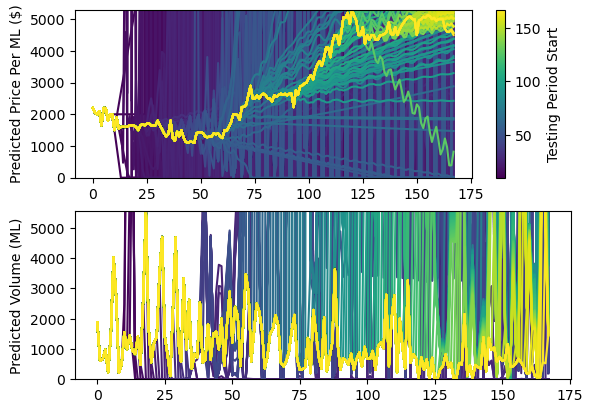

In [12]:
import matplotlib as mpl
from matplotlib import cm

# Plot the predicted volume and price at different starting points for the model                
t = df.index.unique()
x = []

fig, ax = plt.subplots(2)

# Set up for consistent colour mapping
norm = mpl.colors.Normalize(vmin=min(df.start.unique()), vmax=max(df.start.unique()))
map = cm.ScalarMappable(norm=norm, cmap='viridis')

# Plotting the data for different starts
for start in df.start.unique():
    ax[0].plot(t, price(t, x, start), c=map.get_cmap()(norm(start)))
    try:
        ax[1].plot(t, volume(t, x, start), c=map.get_cmap()(norm(start)))
    except:
        pass


# Formatting plot
plt.colorbar(map,ax=ax[0], label="Testing Period Start")

ax[0].set_ylim(0, max(price(t, x, start=max(df.start))))
ax[0].set_ylabel("Predicted Price Per ML ($)")
ax[1].set_ylim(0, max(volume(t, x, start=max(df.start))))
ax[1].set_ylabel("Predicted Volume (ML)")


In [13]:
import scipy
class regression:
    def __init__(self, x, y):
        
        res = scipy.stats.linregress(x, y)
        #res = np.polynomial.polynomial.Polynomial.fit(x, y, 1)
        slope, intercept = res.slope, res.intercept
        #intercept, slope = res.convert().coef
        self.intercept = intercept
        self.slope = slope

In [14]:
def manual_receding(V, t, target_V, start,x, stop_val=0, seed=None):
    # Treat as simple LP, find lowest prices and exploit. No consideration of uncertainty
    V_needed = target_V
   # for 
    P = price(t, x, start=start, seed=seed)
    Vol = volume(t, x, start=start, seed=seed)
    return go_receding(V, t, target_V, P, Vol, stop_val=stop_val)


def go_receding(V, t, target_V, P, Vol, stop_val=0):
    V_needed = target_V
    order = np.argsort(P)
    

    k=0
    last_order = np.argwhere(order==stop_val)
    if len(last_order)==0:
        last_order = len(P)

    for k in np.arange(last_order+1):
        #t_best = t[order[k]]
        V[order[k]] = np.maximum(np.minimum(V_needed, Vol[order[k]]), 0)
        V_needed -= V[order[k]]

        if V_needed <=0:
            break # don't need to calculate the rest

    return V

def use_higher(V, t, target_V, start,x, stop_val=0, seed=None):
    Vol = volume(t, x, start=start, seed=seed)
    P = price_higher(t, x, start=start, seed=seed)
   
    return [np.minimum(np.maximum(target_V - np.sum(Vol[~P]), 0), Vol[0])]

def volume_probability(V, t, target_V, start,x, stop_val=0, seed=None):
    Vol = volume(t, x, start=start, seed=seed)

    total_mean = np.sum(volume(t, x, start)*(1-probability_higher(t, x, start)))
    prob_enough = scipy.stats.norm.cdf(-(target_V - total_mean)/np.sqrt(np.sum(get_column_value(t, x, start, 'Std', use_df=df_vol)**2)))
    
    return np.minimum(Vol, target_V)*prob_enough
    
def combine_probs(V, t, target_V, start,x, stop_val=0, seed=None):
    V = use_higher(V, t, target_V, start,x, stop_val=stop_val, seed=seed)
    if V[0] ==0:
        V = volume_probability(V, t, target_V, start,x, stop_val=stop_val, seed=seed)

    return V

def pick_random(V, t, target_V, start,x, stop_val=0, seed=None):
    # Function to simulate decision being made randomly
    
    Vol = volume(t, x, start=start, seed=seed)
   
    # Instead of starting with lowest price, choose order based on a random variable

    return go_receding(V, t, target_V, np.random.uniform(0, 1, size=len(Vol)), Vol, stop_val=stop_val)

def regress(V, t, target_V, start,x, stop_val=0, seed=None, max_val = 50000):
    starts = df.start.unique()[df.start.unique()<=start]
    Ps = np.empty((len(t), len(starts)))
    Vs = np.empty((len(t), len(starts)))
    for k, start_i in enumerate(starts):
     #   Ps[:, k] = np.maximum(price(t, x, start=start_i, seed=seed), max_val)
        Ps[:, k] = np.minimum(price(t, x, start=start_i, seed=seed), max_val)
        Vs[:, k] = volume(t, x, start=start_i, seed=seed)

    P = np.empty_like(t)
    Vol = np.empty_like(t)
    for j in range(len(t)):
        try:
            # Linear regression on previous predictions for this time
            res = regression(starts, Ps[j, :])
            P[j] = np.sign(res.slope)*np.minimum(abs(res.slope), 100)*(max(t)+1)+res.intercept
            res = regression(starts, Vs[j, :])
            Vol[j] = res.slope*(max(t)+1)+res.intercept
            
        except:
            # Numbers can get too large and cause overflow errors. Setting to 0 ignores these in the algorithm
            P[j] = 0
            Vol[j] = 0
            
    P[0] = price(t, x, start=start, seed=seed)[0]
    Vol[0] = volume(t, x, start=start, seed=seed)[0]
    return go_receding(V, t, target_V, P, Vol, stop_val=stop_val)

def pessimistic(V, t, target_V, start,x, stop_val=0, seed=None):
    # Assume no volume will be available in the future
    P = np.zeros_like(t)
    Vol = np.zeros_like(t)
    P[0] = price(t, x, start=start, seed=seed)[0]
    Vol[0] = volume(t, x, start=start, seed=seed)[0]
    return go_receding(V, t, target_V, P, Vol, stop_val=stop_val)


def run_receding(t, x, target_V, stop_val=0, report=True, report_name="Simple Approach", func=manual_receding, seed=None, func_kwargs={}):

    V = np.zeros_like(t, dtype=np.float64)
    for i in range(len(t)):
        # Get window of time following start time i
        t_window = t[i:]
        V_window = np.zeros_like(t_window, dtype=np.float64)
        V[i] = func(V_window, t_window, target_V-np.sum(V), t[i]+1,x, stop_val=stop_val, seed=seed, **func_kwargs)[0]
    if report:
        report_outcome(V, t, x, tv=target_V, name=report_name, seed=seed)
    return V

def report_outcome(V, t, x, start=None, tv=None, ratio=0.5, name="Run", seed=None):
    if start is None:
        # By default, set the 'start' value to the highest possible to get the true results
        start = max(df.start.unique())
    if tv is None:
        # If target volume not provided, generate one
        tv = set_target_volume(t, x, ratio=ratio)

    # Print results
    print(name)

    if sum(V) < tv:
        # The total volume acquired is less than the target volume.
        print("\t Failed to meet target volume")
        
    total_cost = cost(V, t, x, start, seed=seed)
    print(f"\t Total Cost: ${total_cost:,.2f}")

    return total_cost

In [15]:
t = df.start.unique()[:-1] # Exclude last point to use as ground truth

target_V = set_target_volume(t, x, ratio=0.8)
V = run_receding(t, x, target_V)

V_best = manual_receding(np.zeros_like(t, dtype=np.float64), t, start=max(df.start), target_V=target_V, x=x, stop_val=max(t)+1)
report_outcome(V_best, t, x, tv=target_V, name="Actual Best")

Simple Approach
	 Failed to meet target volume
	 Total Cost: $352,109,721.76
Actual Best
	 Total Cost: $269,464,584.74


269464584.74100006

In [22]:
def plot_decisions(V,t, x, ax):
    # Plot volume available against the volume purchased
    ax.plot(t, volume(t, x,max(df.start)), label="Volume available")
    ax.bar(t, V, color='C1', label="Volume purchased")

    # Add price on secondary axis
    ax2= ax.twinx()
    ax2.fill_between(t, 0, price(t, x,max(df.start)), fc='lavender', zorder=0)
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False) 

    # Formatting
    yl = ax2.get_ylim()
    ax2.set_ylim(0, yl[1])
    ax2.set_ylabel('Price per ML ($)')
    ax.set_ylabel("Volume (ML)")
    ax.set_xlabel("Month")

def plot_cumulative(V, t, x, tv, ax, show_target=True, fstring="Target Volume = {target:,.2f}ML", ylabel= "Total Volume (ML)", label=None):
    ax.plot(t, np.cumsum(V), label=label)

    if show_target:
        ax.axhline(tv, c='k', ls='--')
 
        ax.text(np.mean(t), tv, fstring.format(target=tv), va='bottom', ha='center')
        ax.set_ylim(0, tv*1.5)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Month")

    ax.set_ylim([0, None])

In [29]:
def compare_results(t, x, target_V, funcs, names, seed=None):
    fig, ax = plt.subplots(1+len(funcs), 2, figsize=(10, 5*(1+len(funcs))))
    fig.suptitle("Volume Purchases of Each Method")
    fig2, ax2 = plt.subplots(2)
    fig2.suptitle("Comparison of Results")
    P = price(t, x, start, seed=seed)
    
    V_best = manual_receding(np.zeros_like(t, dtype=np.float64), t, start=max(df.start), target_V=target_V, x=x, stop_val=max(t)+1)
    tc= report_outcome(V_best, t, x, tv=target_V, name="Actual Best")
    ax[0, 0].title.set_text("Theoretical Best")
    plot_decisions(V_best, t, x, ax[0, 0])
    plot_cumulative(V_best, t,x, target_V, ax[0, 1])
    plot_cumulative(V_best, t,x, target_V, ax2[0], label="Theoretical Best")
    plot_cumulative(np.multiply(V_best, P), t,x, tc, ax2[1], fstring="Best Cost ${target:,.2f}", label="Theoretical Best")

    for i, (func, name) in enumerate(zip(funcs, names)):
        V = run_receding(t, x, target_V, func=func, report_name=name)
        ax[1+i, 0].title.set_text(name)
        plot_decisions(V, t, x, ax[1+i, 0])
        plot_cumulative(V, t,x, target_V, ax[1+i, 1])
        plot_cumulative(V, t,x, target_V, ax2[0], show_target=False, label=name)
        plot_cumulative(np.multiply(V, P), t,x, tc, ax2[1], show_target=False, ylabel="Cost ($)", label=name)
        
    
    ax2[1].legend()
    fig2.tight_layout()
    fig.tight_layout()

    return fig

Using matplotlib backend: <object object at 0x000001E46E353E10>


In [30]:
fig = compare_results(t, x, set_target_volume(t, x, 0.8), [manual_receding, use_higher, volume_probability, combine_probs], ["Rolling Optimisation", "Bayesian", "Volume Probability", "Combination"])

Actual Best
	 Total Cost: $269,464,584.74
Rolling Optimisation
	 Failed to meet target volume
	 Total Cost: $352,109,721.76
Bayesian
	 Failed to meet target volume
	 Total Cost: $355,523,004.44


C:\Users\Meredith\AppData\Local\Temp\ipykernel_2524\2023691405.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  prob_enough = scipy.stats.norm.cdf(-(target_V - total_mean)/np.sqrt(np.sum(get_column_value(t, x, start, 'Std', use_df=df_vol)**2)))


Volume Probability
	 Failed to meet target volume
	 Total Cost: $236,949,170.86


C:\Users\Meredith\AppData\Local\Temp\ipykernel_2524\2023691405.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  prob_enough = scipy.stats.norm.cdf(-(target_V - total_mean)/np.sqrt(np.sum(get_column_value(t, x, start, 'Std', use_df=df_vol)**2)))


Combination
	 Total Cost: $275,374,754.57


Actual Best
	 Failed to meet target volume
	 Total Cost: $44,409,739.21
Rolling Optimisation
	 Total Cost: $56,629,316.15
Regressive Optimisation
	 Failed to meet target volume
	 Total Cost: $86,058,160.88
Pessimistic Optimisation
	 Total Cost: $57,251,479.48
Probabilistic
	 Failed to meet target volume
	 Total Cost: $57,642,227.18


C:\Users\Meredith\AppData\Local\Temp\ipykernel_2524\2023691405.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  prob_enough = scipy.stats.norm.cdf(-(target_V - total_mean)/np.sqrt(np.sum(get_column_value(t, x, start, 'Std', use_df=df_vol)**2)))


Volume Distribution
	 Total Cost: $51,652,193.18


C:\Users\Meredith\AppData\Local\Temp\ipykernel_2524\2023691405.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  prob_enough = scipy.stats.norm.cdf(-(target_V - total_mean)/np.sqrt(np.sum(get_column_value(t, x, start, 'Std', use_df=df_vol)**2)))


Combination
	 Failed to meet target volume
	 Total Cost: $57,296,132.90


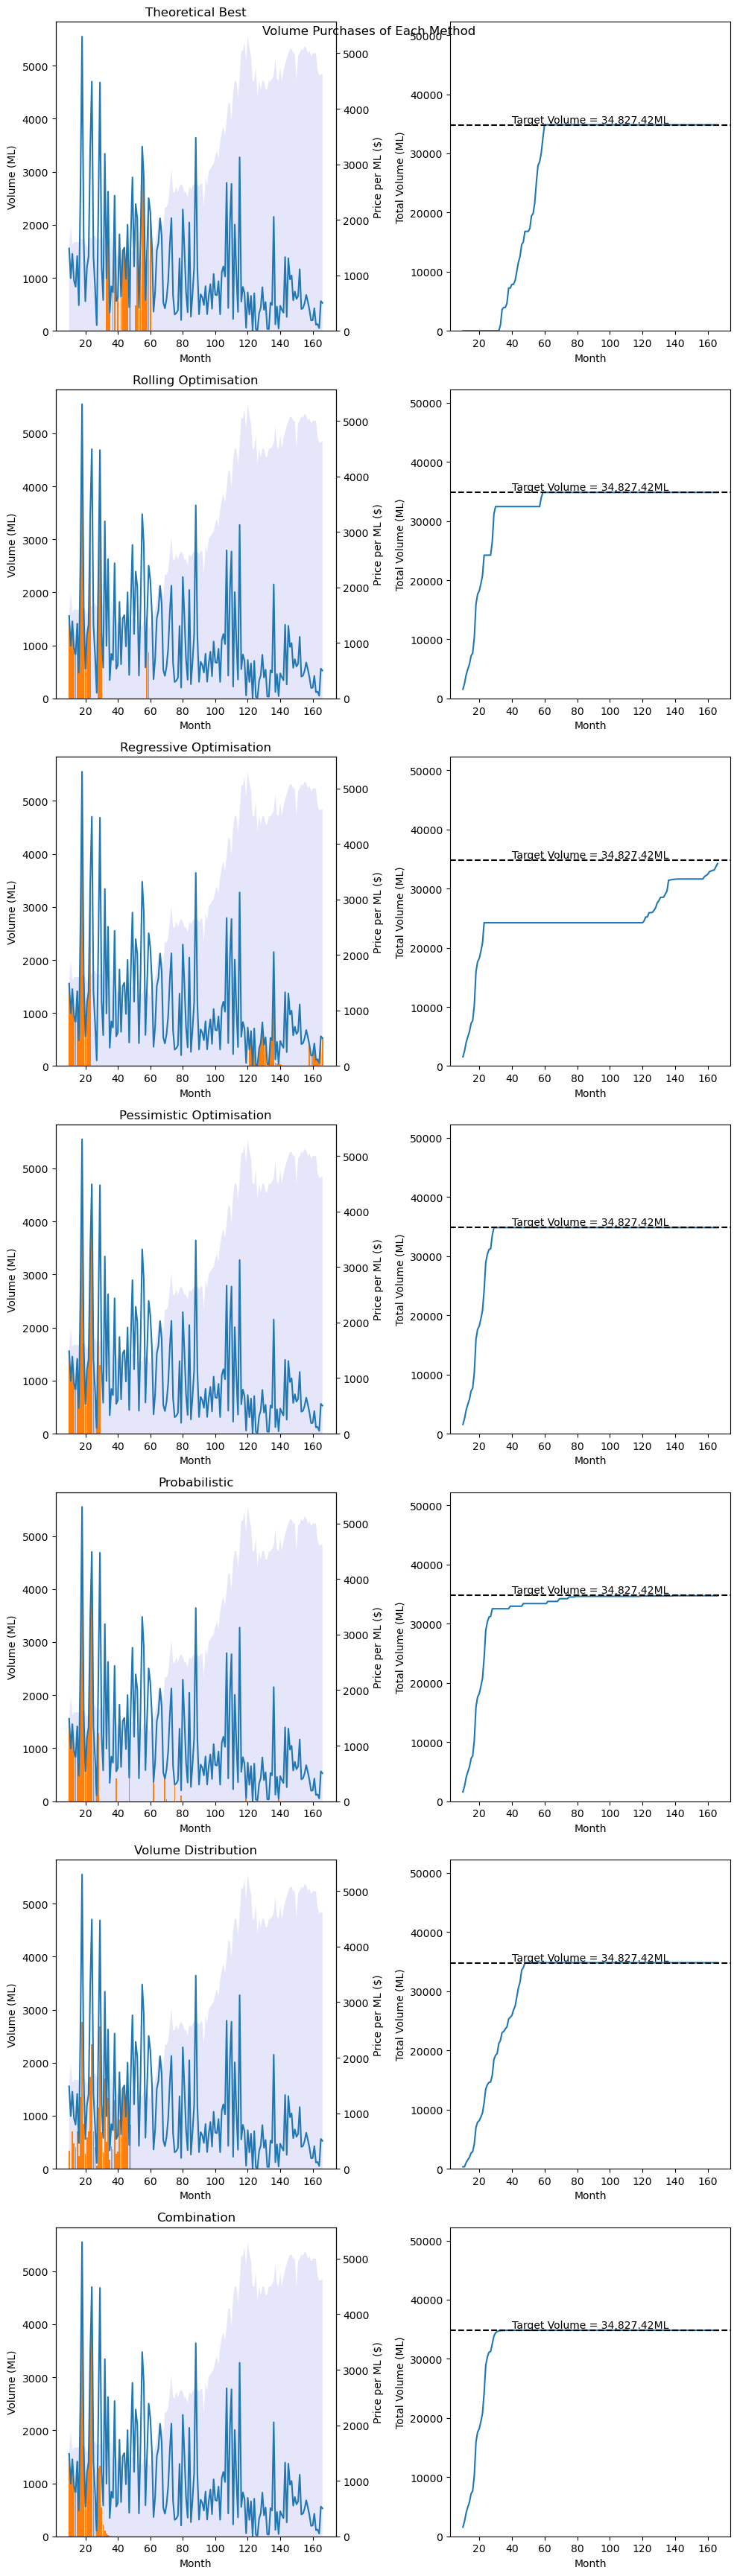

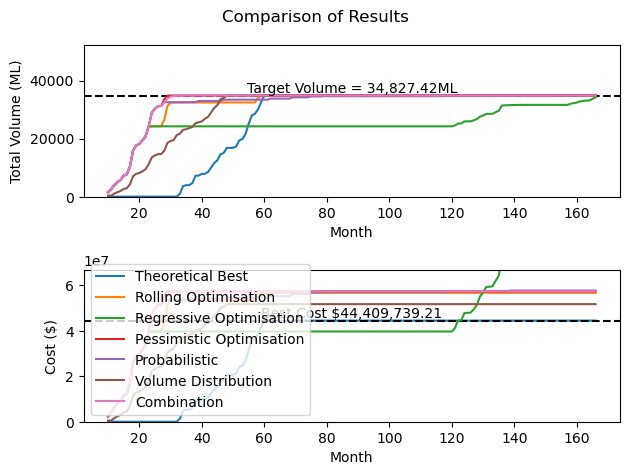

In [27]:
fig = compare_results(t, x, set_target_volume(t,x, ratio=0.2), [manual_receding, regress, pessimistic, use_higher, volume_probability, combine_probs], ["Rolling Optimisation", "Regressive Optimisation", "Pessimistic Optimisation", "Probabilistic", 'Volume Distribution', "Combination"])


Actual Best
	 Failed to meet target volume
	 Total Cost: $347,347,689.94
Rolling Optimisation
	 Failed to meet target volume
	 Total Cost: $353,275,508.31
Regressive Optimisation
	 Failed to meet target volume
	 Total Cost: $258,093,271.70
Pessimistic Optimisation
	 Total Cost: $349,429,436.99
Bayesian
	 Failed to meet target volume
	 Total Cost: $383,154,585.90


C:\Users\Meredith\AppData\Local\Temp\ipykernel_2524\2023691405.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  prob_enough = scipy.stats.norm.cdf(-(target_V - total_mean)/np.sqrt(np.sum(get_column_value(t, x, start, 'Std', use_df=df_vol)**2)))


Volume Probability
	 Failed to meet target volume
	 Total Cost: $217,877,648.14


C:\Users\Meredith\AppData\Local\Temp\ipykernel_2524\2023691405.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  prob_enough = scipy.stats.norm.cdf(-(target_V - total_mean)/np.sqrt(np.sum(get_column_value(t, x, start, 'Std', use_df=df_vol)**2)))


COmbination
	 Failed to meet target volume
	 Total Cost: $355,042,435.61


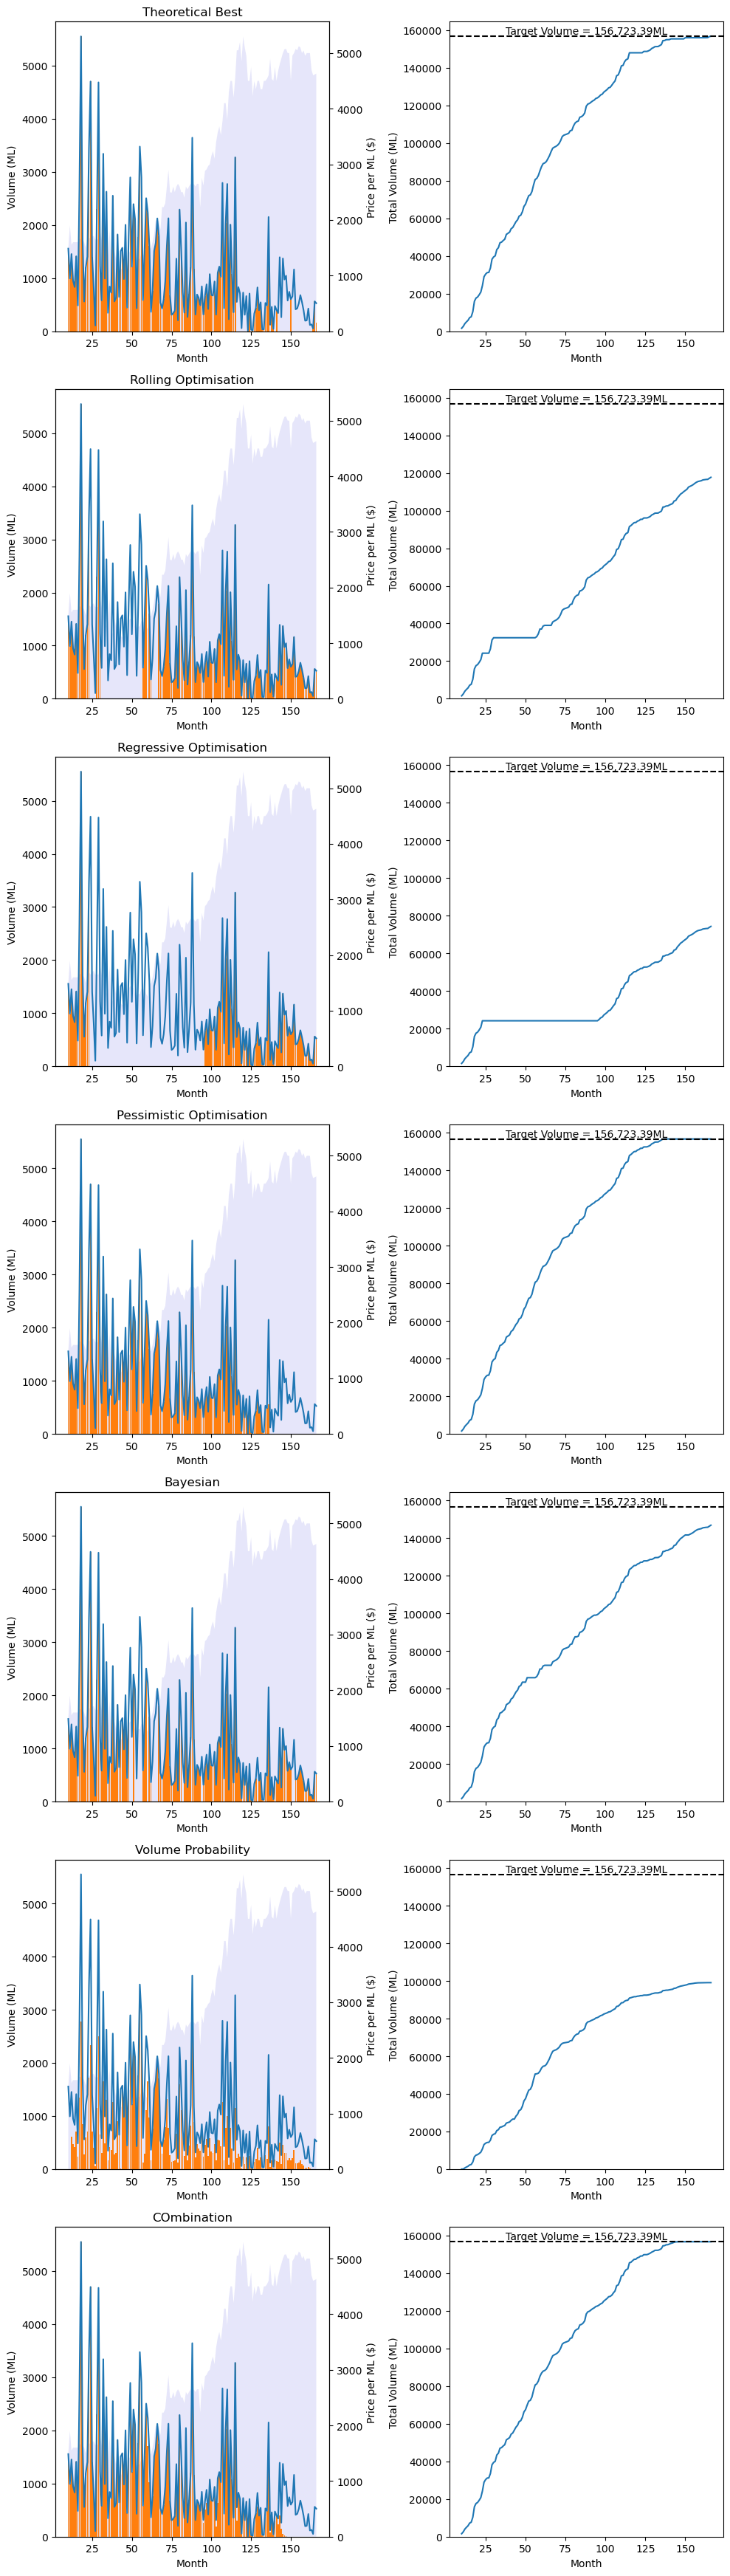

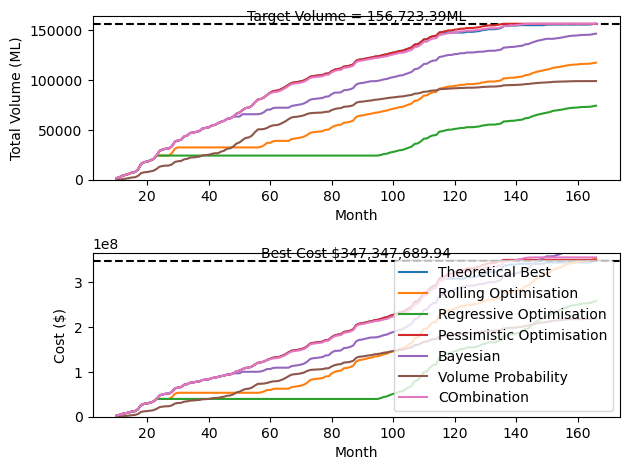

In [21]:
fig = compare_results(t, x, set_target_volume(t,x, ratio=0.9), [manual_receding, regress, pessimistic, use_higher, volume_probability, combine_probs], ["Rolling Optimisation", "Regressive Optimisation", "Pessimistic Optimisation", "Bayesian", 'Volume Probability', "COmbination"])

Actual Best
	 Total Cost: $269,464,584.74
Rolling Optimisation
	 Failed to meet target volume
	 Total Cost: $352,109,721.76
Regressive Optimisation
	 Failed to meet target volume
	 Total Cost: $282,454,051.70
Pessimistic Optimisation
	 Total Cost: $269,970,780.74
Bayesian
	 Failed to meet target volume
	 Total Cost: $355,523,004.44


C:\Users\Meredith\AppData\Local\Temp\ipykernel_3764\1013072981.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  prob_enough = scipy.stats.norm.cdf(-(target_V - total_mean)/np.sum(get_column_value(t, x, start, 'Std', use_df=df_vol)))


Volume Probability
	 Failed to meet target volume
	 Total Cost: $224,748,474.67


C:\Users\Meredith\AppData\Local\Temp\ipykernel_3764\1013072981.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  prob_enough = scipy.stats.norm.cdf(-(target_V - total_mean)/np.sum(get_column_value(t, x, start, 'Std', use_df=df_vol)))


COmbination
	 Total Cost: $291,982,315.45


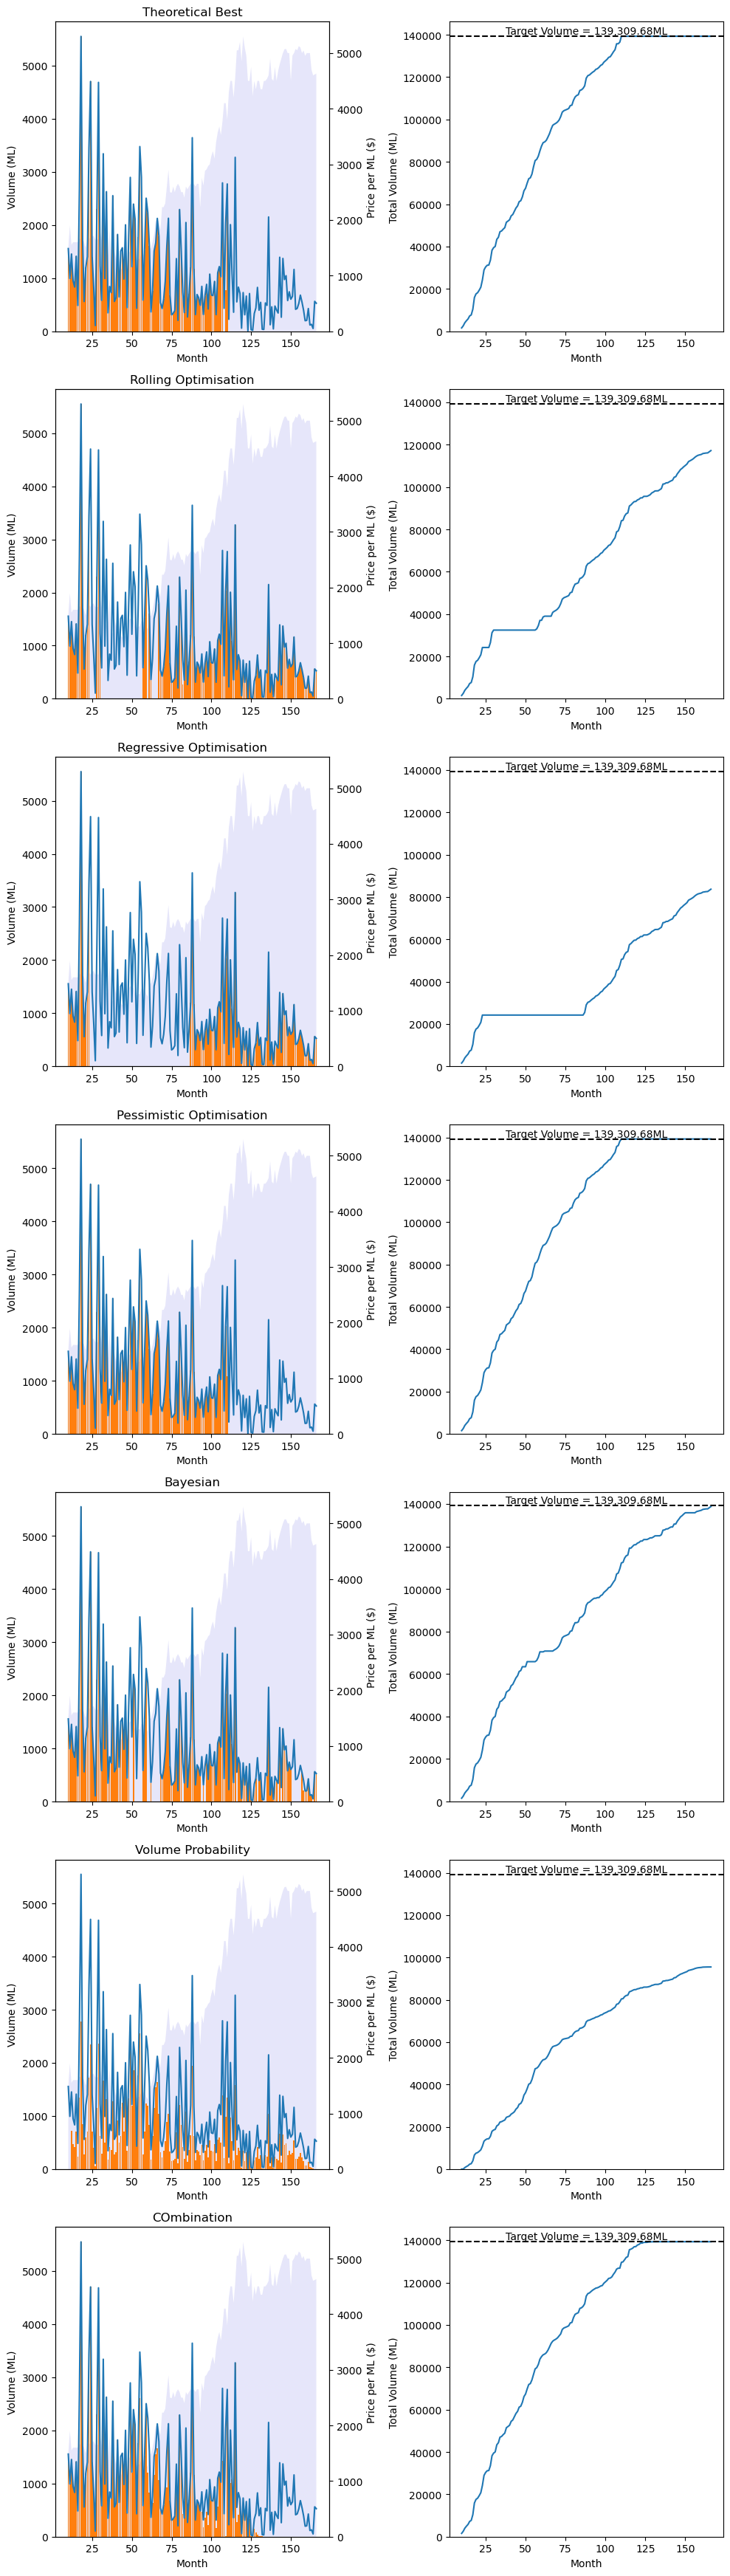

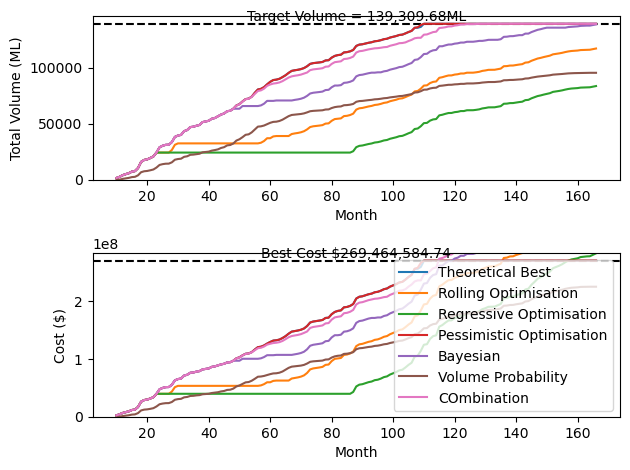

In [441]:
fig = compare_results(t, x, target_V, [manual_receding, regress, pessimistic, use_higher, volume_probability, combine_probs], ["Rolling Optimisation", "Regressive Optimisation", "Pessimistic Optimisation", "Bayesian", 'Volume Probability', "COmbination"])

In [99]:
iterations = 10

# Run for a number of iterations with randomness and see distribution of results 

funcs = [pick_random, manual_receding, regress]
Vs= np.empty((t.shape[0], iterations, len(funcs)))
Vs[:] = np.nan
Cs=np.empty((iterations, len(funcs)))
Cs[:] = np.nan

for it in np.arange(iterations):
    for func_i, func in enumerate(funcs):
        V = run_receding(t, x, target_V, seed=it, report=False, func=func)
        if sum(V) >= target_V:
            Vs[:, it, func_i] = V
            Cs[it, func_i] = cost(V, t, x, start=max(df.start))


IndexError: indices are out-of-bounds

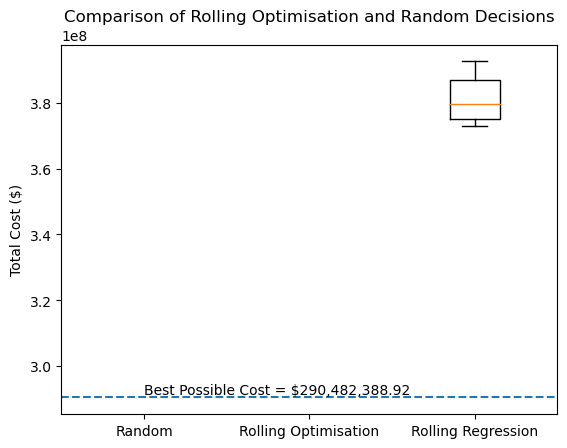

In [ ]:
fig, ax = plt.subplots()
ax.boxplot([Cs[:, i] for i in range(Cs.shape[-1])])

best_cost = cost(V_best, t, x)
ax.axhline(best_cost, ls='--')
ax.text(1, best_cost, f'Best Possible Cost = ${best_cost:,.2f}', va='bottom')
ax.set_xticks([1, 2, 3], labels=["Random", "Rolling Optimisation", "Rolling Regression"])

ax.set_ylabel("Total Cost ($)")
ax.title.set_text('Comparison of Rolling Optimisation and Random Decisions')

plt.savefig("Rolling vs Random.png", dpi=300)